# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Analyze Imaging Type Distribution

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
def create_vgg_model(architecture='vgg16', num_classes=4, pretrained=True):
    """Create VGG model for multi-class classification"""
    if architecture == 'vgg16':
        model = models.vgg16(weights='DEFAULT' if pretrained else None)
    elif architecture == 'vgg19':
        model = models.vgg19(weights='DEFAULT' if pretrained else None)
    else:
        raise ValueError("Architecture must be 'vgg16' or 'vgg19'")
    
    # Modify the final fully connected layer for our number of classes
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train VGG16

Training VGG16 (without Imaging Type)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 243MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.36it/s, Loss=1.5585, Acc=0.3692]


Train Loss: 1.5585 Acc: 0.3692 Macro-F1: 0.2992


Val : 100%|██████████| 10/10 [00:01<00:00,  6.32it/s, Loss=1.1322, Acc=0.4770]


Val Loss: 1.1322 Acc: 0.4770 Macro-F1: 0.4093
✓ New best model saved with validation macro-F1: 0.4093

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=1.1354, Acc=0.5189]


Train Loss: 1.1354 Acc: 0.5189 Macro-F1: 0.4659


Val : 100%|██████████| 10/10 [00:01<00:00,  8.27it/s, Loss=1.0197, Acc=0.5164]


Val Loss: 1.0197 Acc: 0.5164 Macro-F1: 0.4682
✓ New best model saved with validation macro-F1: 0.4682

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=1.0453, Acc=0.5518]


Train Loss: 1.0453 Acc: 0.5518 Macro-F1: 0.5031


Val : 100%|██████████| 10/10 [00:01<00:00,  8.27it/s, Loss=1.0024, Acc=0.4901]


Val Loss: 1.0024 Acc: 0.4901 Macro-F1: 0.4673

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.9221, Acc=0.6168]


Train Loss: 0.9221 Acc: 0.6168 Macro-F1: 0.5766


Val : 100%|██████████| 10/10 [00:01<00:00,  8.18it/s, Loss=1.0746, Acc=0.3553]


Val Loss: 1.0746 Acc: 0.3553 Macro-F1: 0.3249

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.8276, Acc=0.6546]


Train Loss: 0.8276 Acc: 0.6546 Macro-F1: 0.6143


Val : 100%|██████████| 10/10 [00:01<00:00,  8.21it/s, Loss=1.1433, Acc=0.5921]


Val Loss: 1.1433 Acc: 0.5921 Macro-F1: 0.5438
✓ New best model saved with validation macro-F1: 0.5438

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.8461, Acc=0.6859]


Train Loss: 0.8461 Acc: 0.6859 Macro-F1: 0.6452


Val : 100%|██████████| 10/10 [00:01<00:00,  8.19it/s, Loss=0.7471, Acc=0.6842]


Val Loss: 0.7471 Acc: 0.6842 Macro-F1: 0.6514
✓ New best model saved with validation macro-F1: 0.6514

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.72it/s, Loss=0.6515, Acc=0.7574]


Train Loss: 0.6515 Acc: 0.7574 Macro-F1: 0.7209


Val : 100%|██████████| 10/10 [00:01<00:00,  8.06it/s, Loss=0.5115, Acc=0.7928]


Val Loss: 0.5115 Acc: 0.7928 Macro-F1: 0.7621
✓ New best model saved with validation macro-F1: 0.7621

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.3444, Acc=0.8766]


Train Loss: 0.3444 Acc: 0.8766 Macro-F1: 0.8632


Val : 100%|██████████| 10/10 [00:01<00:00,  8.32it/s, Loss=0.3962, Acc=0.8684]


Val Loss: 0.3962 Acc: 0.8684 Macro-F1: 0.8446
✓ New best model saved with validation macro-F1: 0.8446

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.2903, Acc=0.8947]


Train Loss: 0.2903 Acc: 0.8947 Macro-F1: 0.8790


Val : 100%|██████████| 10/10 [00:01<00:00,  8.19it/s, Loss=0.3266, Acc=0.9145]


Val Loss: 0.3266 Acc: 0.9145 Macro-F1: 0.8995
✓ New best model saved with validation macro-F1: 0.8995

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.2074, Acc=0.9137]


Train Loss: 0.2074 Acc: 0.9137 Macro-F1: 0.9018


Val : 100%|██████████| 10/10 [00:01<00:00,  8.21it/s, Loss=0.2923, Acc=0.9145]


Val Loss: 0.2923 Acc: 0.9145 Macro-F1: 0.9034
✓ New best model saved with validation macro-F1: 0.9034

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1942, Acc=0.9235]


Train Loss: 0.1942 Acc: 0.9235 Macro-F1: 0.9147


Val : 100%|██████████| 10/10 [00:01<00:00,  8.22it/s, Loss=0.3099, Acc=0.9079]


Val Loss: 0.3099 Acc: 0.9079 Macro-F1: 0.8830

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.1501, Acc=0.9441]


Train Loss: 0.1501 Acc: 0.9441 Macro-F1: 0.9355


Val : 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Loss=0.3111, Acc=0.9013]


Val Loss: 0.3111 Acc: 0.9013 Macro-F1: 0.8884

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1513, Acc=0.9474]


Train Loss: 0.1513 Acc: 0.9474 Macro-F1: 0.9420


Val : 100%|██████████| 10/10 [00:01<00:00,  8.25it/s, Loss=0.2650, Acc=0.9276]


Val Loss: 0.2650 Acc: 0.9276 Macro-F1: 0.9173
✓ New best model saved with validation macro-F1: 0.9173

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.1315, Acc=0.9474]


Train Loss: 0.1315 Acc: 0.9474 Macro-F1: 0.9421


Val : 100%|██████████| 10/10 [00:01<00:00,  8.02it/s, Loss=0.2673, Acc=0.9243]


Val Loss: 0.2673 Acc: 0.9243 Macro-F1: 0.9115

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.1038, Acc=0.9638]


Train Loss: 0.1038 Acc: 0.9638 Macro-F1: 0.9609


Val : 100%|██████████| 10/10 [00:01<00:00,  8.09it/s, Loss=0.2594, Acc=0.9276]


Val Loss: 0.2594 Acc: 0.9276 Macro-F1: 0.9141

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1024, Acc=0.9679]


Train Loss: 0.1024 Acc: 0.9679 Macro-F1: 0.9661


Val : 100%|██████████| 10/10 [00:01<00:00,  8.21it/s, Loss=0.2568, Acc=0.9243]


Val Loss: 0.2568 Acc: 0.9243 Macro-F1: 0.9115

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.0961, Acc=0.9655]


Train Loss: 0.0961 Acc: 0.9655 Macro-F1: 0.9676


Val : 100%|██████████| 10/10 [00:01<00:00,  8.19it/s, Loss=0.2553, Acc=0.9276]


Val Loss: 0.2553 Acc: 0.9276 Macro-F1: 0.9141

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.0824, Acc=0.9720]


Train Loss: 0.0824 Acc: 0.9720 Macro-F1: 0.9718


Val : 100%|██████████| 10/10 [00:01<00:00,  8.25it/s, Loss=0.2543, Acc=0.9276]


Val Loss: 0.2543 Acc: 0.9276 Macro-F1: 0.9141
Early stopping triggered after 18 epochs
Training complete in 3m 40s
Best validation macro-F1: 0.9173


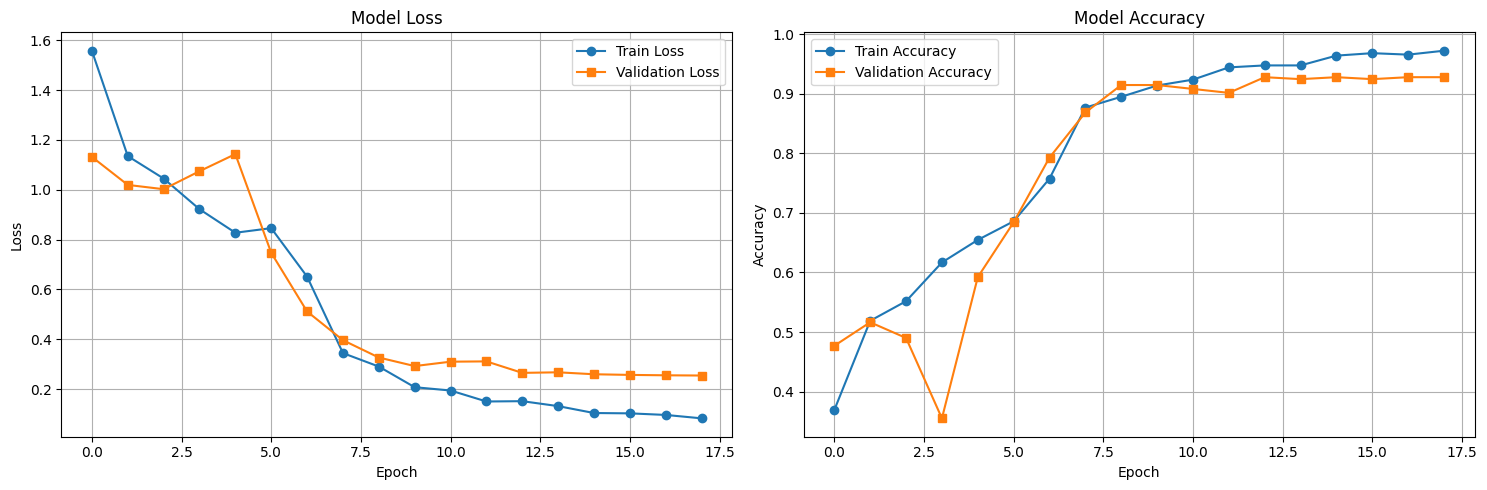

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


Test Accuracy: 51.85%
Test Loss: 3.3470

Classification Report:
              precision    recall  f1-score   support

         HGC       0.84      0.93      0.88        74
         LGC       0.24      0.19      0.21        53
         NST       0.42      0.49      0.45        37
         NTL       0.04      0.04      0.04        25

    accuracy                           0.52       189
   macro avg       0.39      0.41      0.40       189
weighted avg       0.49      0.52      0.50       189


Confusion Matrix:
[[69  1  0  4]
 [11 10 14 18]
 [ 1 18 18  0]
 [ 1 12 11  1]]

ROC-AUC Scores:
Macro-average AUC: 0.5908
Micro-average AUC: 0.6662
HGC AUC: 0.9633
LGC AUC: 0.4206
NST AUC: 0.7025
NTL AUC: 0.2768


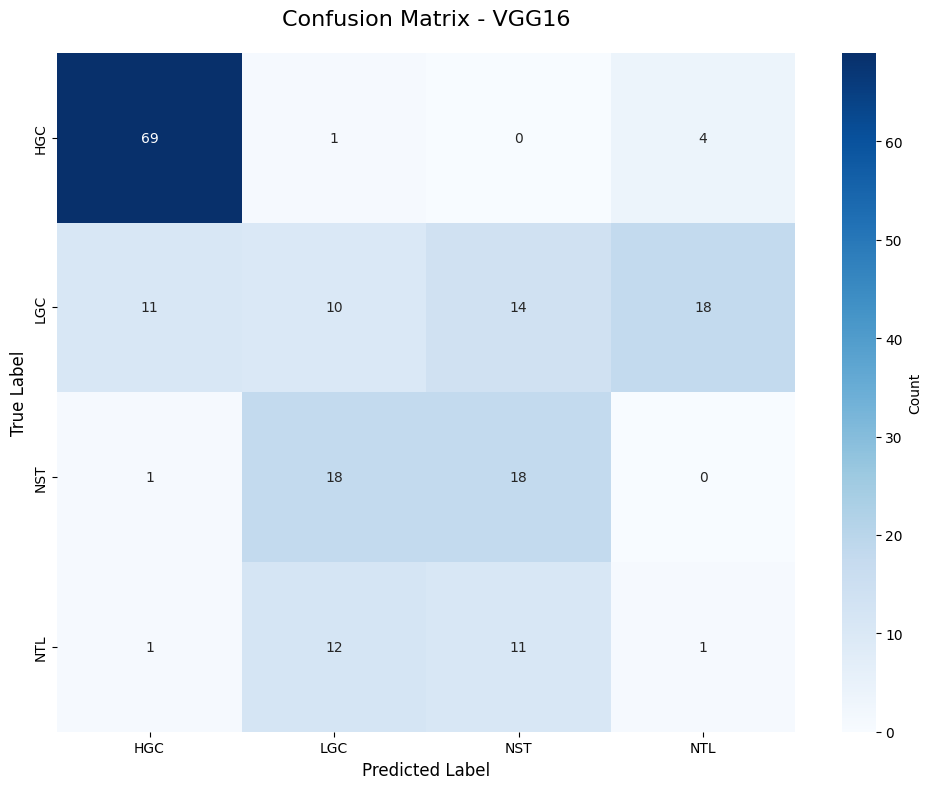

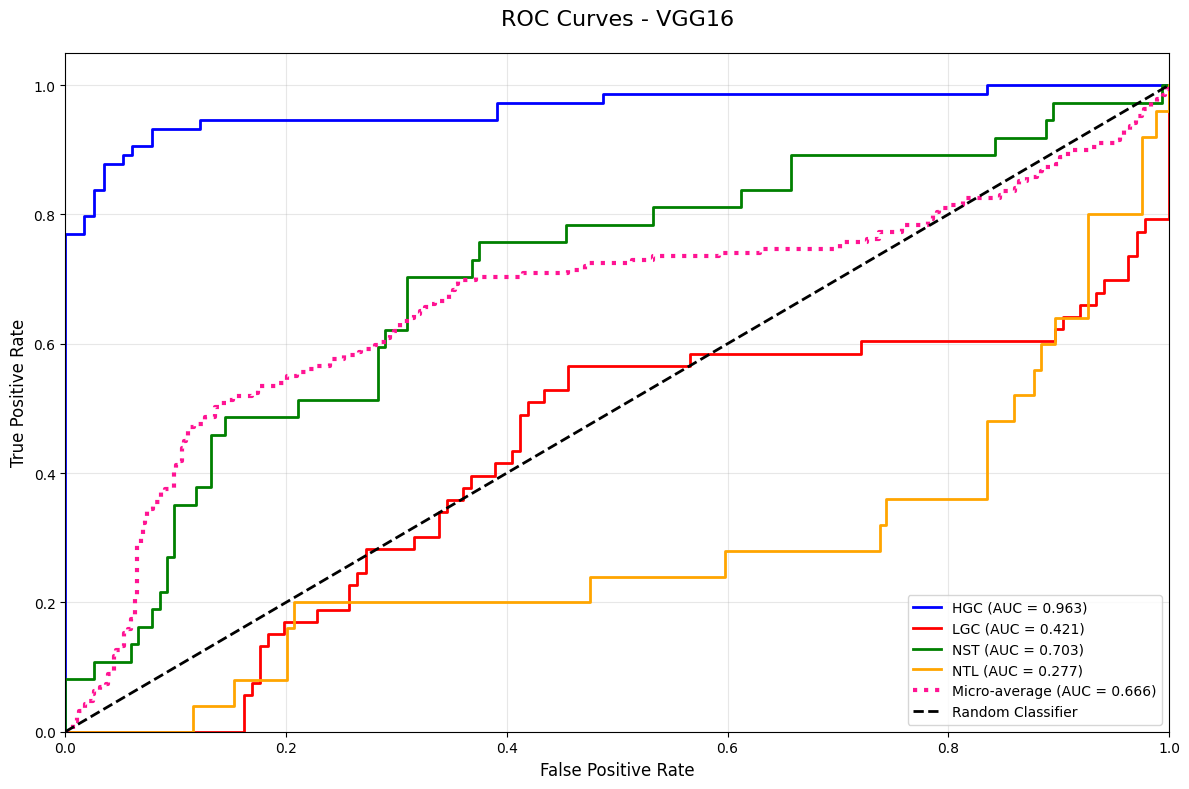


VGG16 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training VGG16 (without Imaging Type)")
print("=" * 80)

# Create model
vgg16 = create_vgg_model(architecture='vgg16', num_classes=4, pretrained=True)

# Create trainer
trainer_vgg16 = ModelTrainer(vgg16, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vgg16 = trainer_vgg16.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="VGG16")

# Plot training history
trainer_vgg16.plot_training_history(save_path='vgg16_training_history.png')

# Evaluate model
results_vgg16 = trainer_vgg16.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vgg16['confusion_matrix'], class_names, 'VGG16',
                      save_path='vgg16_confusion_matrix.png')

# Plot ROC curves
roc_auc_vgg16 = plot_roc_curves(results_vgg16['labels'], results_vgg16['probabilities'], class_names, 'VGG16',
                                save_path='vgg16_roc_curves.png')

# Store results
results_vgg16['model_name'] = 'VGG16'
results_vgg16['roc_auc'] = roc_auc_vgg16
all_results.append(results_vgg16)

print("\nVGG16 training and evaluation complete!")

## Train VGG19

Training VGG19 (without Imaging Type)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 204MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.7949, Acc=0.2714]


Train Loss: 1.7949 Acc: 0.2714 Macro-F1: 0.2490


Val : 100%|██████████| 10/10 [00:01<00:00,  7.25it/s, Loss=1.3503, Acc=0.3421]


Val Loss: 1.3503 Acc: 0.3421 Macro-F1: 0.1898
✓ New best model saved with validation macro-F1: 0.1898

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.4051, Acc=0.2558]


Train Loss: 1.4051 Acc: 0.2558 Macro-F1: 0.2244


Val : 100%|██████████| 10/10 [00:01<00:00,  7.46it/s, Loss=1.3627, Acc=0.3059]


Val Loss: 1.3627 Acc: 0.3059 Macro-F1: 0.1750

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.4298, Acc=0.2229]


Train Loss: 1.4298 Acc: 0.2229 Macro-F1: 0.2170


Val : 100%|██████████| 10/10 [00:01<00:00,  7.40it/s, Loss=1.3883, Acc=0.3684]


Val Loss: 1.3883 Acc: 0.3684 Macro-F1: 0.1346

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.4028, Acc=0.2623]


Train Loss: 1.4028 Acc: 0.2623 Macro-F1: 0.2273


Val : 100%|██████████| 10/10 [00:01<00:00,  7.39it/s, Loss=1.3656, Acc=0.2829]


Val Loss: 1.3656 Acc: 0.2829 Macro-F1: 0.1103

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.4229, Acc=0.2821]


Train Loss: 1.4229 Acc: 0.2821 Macro-F1: 0.2205


Val : 100%|██████████| 10/10 [00:01<00:00,  7.44it/s, Loss=1.3621, Acc=0.3684]


Val Loss: 1.3621 Acc: 0.3684 Macro-F1: 0.1346

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.4030, Acc=0.2311]


Train Loss: 1.4030 Acc: 0.2311 Macro-F1: 0.2137


Val : 100%|██████████| 10/10 [00:01<00:00,  7.43it/s, Loss=1.3486, Acc=0.3684]


Val Loss: 1.3486 Acc: 0.3684 Macro-F1: 0.1346
Early stopping triggered after 6 epochs
Training complete in 1m 20s
Best validation macro-F1: 0.1898


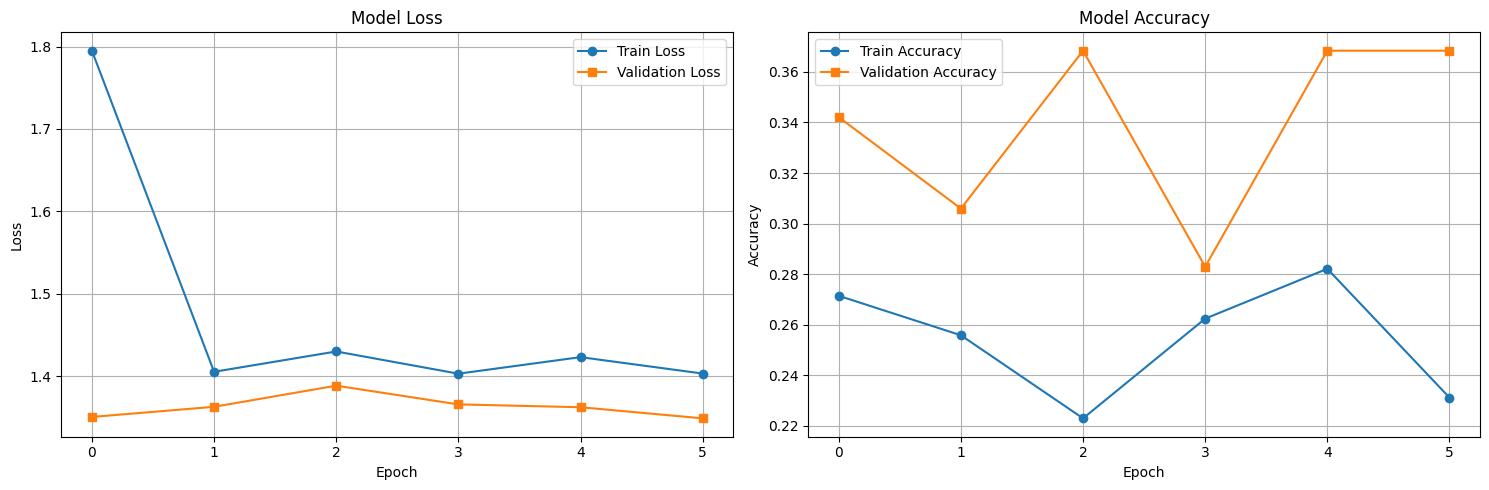

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 40.21%
Test Loss: 1.3391

Classification Report:
              precision    recall  f1-score   support

         HGC       0.42      1.00      0.59        74
         LGC       0.15      0.04      0.06        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.40       189
   macro avg       0.14      0.26      0.16       189
weighted avg       0.21      0.40      0.25       189


Confusion Matrix:
[[74  0  0  0]
 [51  2  0  0]
 [28  9  0  0]
 [23  2  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.5404
Micro-average AUC: 0.6416
HGC AUC: 0.9137
LGC AUC: 0.0966
NST AUC: 0.6406
NTL AUC: 0.5105


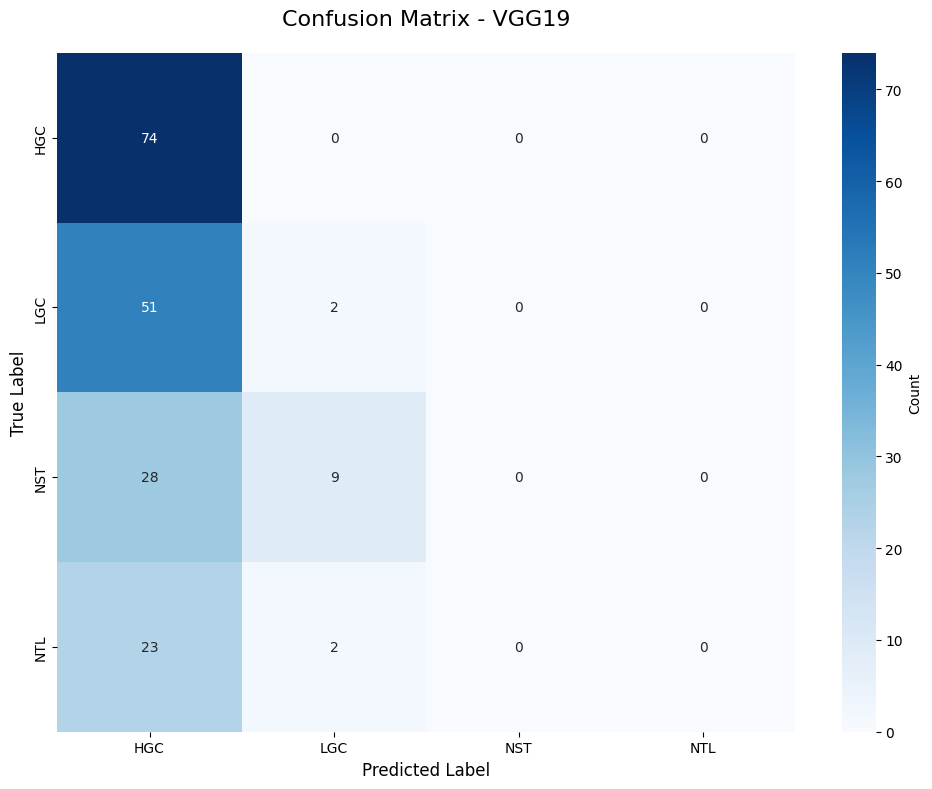

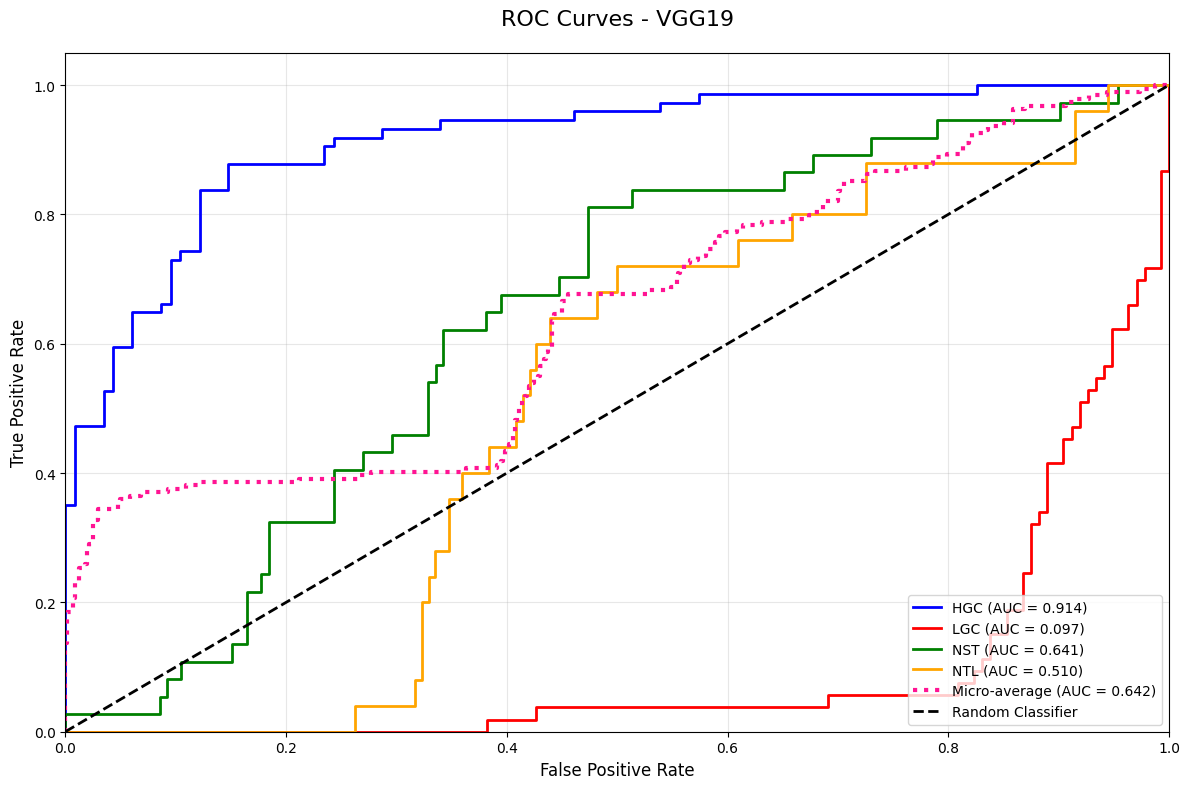


VGG19 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training VGG19 (without Imaging Type)")
print("=" * 80)

# Create model
vgg19 = create_vgg_model(architecture='vgg19', num_classes=4, pretrained=True)

# Create trainer
trainer_vgg19 = ModelTrainer(vgg19, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vgg19 = trainer_vgg19.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="VGG19")

# Plot training history
trainer_vgg19.plot_training_history(save_path='vgg19_training_history.png')

# Evaluate model
results_vgg19 = trainer_vgg19.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vgg19['confusion_matrix'], class_names, 'VGG19',
                      save_path='vgg19_confusion_matrix.png')

# Plot ROC curves
roc_auc_vgg19 = plot_roc_curves(results_vgg19['labels'], results_vgg19['probabilities'], class_names, 'VGG19',
                                save_path='vgg19_roc_curves.png')

# Store results
results_vgg19['model_name'] = 'VGG19'
results_vgg19['roc_auc'] = roc_auc_vgg19
all_results.append(results_vgg19)

print("\nVGG19 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'VGG_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: VGG_metrics.csv

Metrics Summary:
   Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall  NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  VGG16         51.851852      3.347015             0.386862          0.411900      0.397262                0.485558             0.518519         0.499629       0.841463    0.932432  0.884615         74.0       0.243902    0.188679  0.212766         53.0       0.418605    0.486486    0.45         37.0       0.043478        0.04  0.041667         25.0   0.590834   0.666209  0.963337  0.420644  0.702525  0.276829      0.963337      0.420644      0.7025